In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

from physicsCA import physicsCA, make_kernel, min_max
import pygame

pygame 2.0.1 (SDL 2.0.14, Python 3.9.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
size = 128 + 1  # +1 for symmetry
A = -1.  # Acceleration constant A = [m / s^2]
mass_const = 1e+3  # Mass
dt = 1.
temp = 5e-2

In [3]:
def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, :, i, j] = 10.
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, :, i, j] = -1.
    return state

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), CHANNELS)
    
    return cdim_order
    
def WHEEL_beta(beta, direction):
    
    return beta + direction * 0.01

# Test

In [4]:
CHANNELS=2
RADIUS=3
ca = physicsCA(CHANNELS=CHANNELS, RADIUS=RADIUS).cuda() 

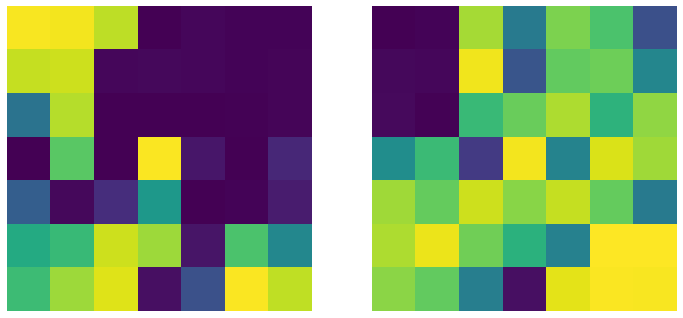

In [5]:
kernels = torch.cat([k for k in ca.rule.kernel], dim=0).cpu().detach().numpy()

num_plot_kernels = np.min([6, CHANNELS])
fig, axes = plt.subplots(1, num_plot_kernels, figsize=(12, 9))

for j in range(num_plot_kernels):
    kplot = kernels[j, :, :]
    kmax = np.max(np.abs(kplot))
    axes[j].imshow(kplot, vmin=-kmax, vmax=kmax)
    axes[j].axis('off')


In [6]:
# brush properties
r = 20
s = 1

In [7]:
# resolution of grid
RESX=480
RESY=240

# pygame stuff
######################################
pygame.init()
size = RESX, RESY
# screen = pygame.display.set_mode(size)
screen = pygame.Surface(size)
UPSCALE = 2
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

running = True
time_ticking = True
self_organize = False
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################

device = 'cuda'
mass = (torch.rand(1, 1, RESX, RESY, requires_grad=False, device=device) > 0.5) * 1.      # mass = [kg]
force = torch.zeros(2, 1, RESX, RESY, requires_grad=False, device=device)    # force = [kg * m / s^2]
momentum = torch.zeros(2, 1, RESX, RESY, requires_grad=False, device=device) # momentum = [kg * m / s]


update_rate = 1.
ticker = 0.
sink = False
export_imgs = False
imgs = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = event.y
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_LEFTBRACKET:
                ca.rule.kpow += -0.05
                ca.rule.kernel = make_kernel(pow=ca.rule.kpow)
            if event.type == pygame.KEYDOWN and event.key == pygame.K_RIGHTBRACKET:
                ca.rule.kpow += 0.05
                ca.rule.kernel = make_kernel(pow=ca.rule.kpow)
            
            if event.type == pygame.KEYDOWN and event.key == pygame.K_k:
                ca.rule.kernel = ca.rule.generate_cppn_kernel()

            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type == pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_r:
                # reinit
                mass = (torch.rand(1, 1, RESX, RESY, requires_grad=False, device=device) > 0.5) * 1.      # mass = [kg]
                force = torch.zeros(2, 1, RESX, RESY, requires_grad=False, device=device)    # force = [kg * m / s^2]
                momentum = torch.zeros(2, 1, RESX, RESY, requires_grad=False, device=device) # momentum = [kg * m / s]
                

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            mass = LMB_make(mass, r=r, s=s)
        if RMB_trigger:
            mass = RMB_del(mass, r=r, s=s)
        
        #nx = mass.cpu()[0, 0, :, :].numpy() 
        nx = [mass[0, 0, :, :], momentum.norm(p=2, dim=0, keepdim=True)[0, 0], force.norm(p=2, dim=0, keepdim=True)[0, 0]]
        nx = min_max(torch.stack([min_max(c.log1p()) for c in nx], dim=-1).cpu().numpy()) * 255.
        
        # nx = torch.stack([mass.cpu()[0, 0, :, :], momentum.cpu().norm(p=2, dim=0, keepdim=True)[0, 0], force.cpu().norm(p=2, dim=0, keepdim=True)[0, 0]], dim=-1).numpy()
#         nx = nx * 255.

        if time_ticking:
            mass, momentum, force = ca.forward(mass, momentum, force, A, dt, temp)
            ticker += 1


        if export_imgs and time_ticking:
            imgs.append(nx)


        pygame.surfarray.blit_array(screen, nx)        
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        pygame.display.flip()
        clock.tick(240)
        
pygame.quit()


In [8]:
fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RESX, RESY), 3)
out = cv2.VideoWriter(f'videos/CA-{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 60, (RESX, RESY), 3)


for img in imgs:
#     img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)).transpose(1, 0, 2)
    out.write(img)
out.release()

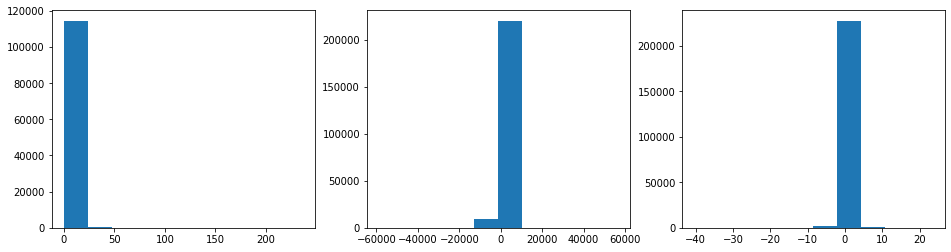

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].hist(mass.reshape(-1).cpu().detach().numpy());
axes[1].hist(momentum.reshape(-1).cpu().detach().numpy());
axes[2].hist(force.reshape(-1).cpu().detach().numpy());